<div style="text-align: center; font-family: Arial, sans-serif; padding: 20px;">
    <h2 style="font-size: 1.5em; font-weight: bold;">UNIVERSIDAD NACIONAL DE SAN AGUSTÍN DE AREQUIPA</h2>
    <h3 style="font-size: 1.2em; font-weight: bold;">FACULTAD DE PRODUCCIÓN Y SERVICIOS</h3>
    <h3 style="font-size: 1.2em; font-weight: bold;">ESCUELA PROFESIONAL DE INGENIERÍA EN TELECOMUNICACIONES</h3>
    <div style="margin: 20px 0;">
        <img src="../images/Escudo_UNSA.png" alt="Escudo de la universidad" style="width: 150px; height: auto;">
    </div>
    <h2 style="font-size: 1.5em; font-weight: bold;">REDES INALÁMBRICAS</h2>
    <h3 style="font-size: 1.2em; font-weight: bold; font-style: italic;">
        SIMULACION - PRACTICA 3
    </h3>
    <p style="text-align: center; font-size: 1em; margin-top: 30px;">
        <strong>Docente:</strong><br>
        Dr. Alexander Hilario Tacuri
    </p>
    <p style="text-align: center; font-size: 1em;">
        <strong>Integrantes:</strong><br>
        Chavez Ponce Jorge Alberto<br>
        Cana Remache Javier Ricardo<br>
        Neyra Torres Luis Kenny<br>
        Yllachura Arapa Rosangela
    </p>
    <p style="margin-top: 50px; font-size: 1.2em; font-weight: bold; text-align: center;">
        AREQUIPA – PERÚ
    </p>
    <p style="font-size: 1em; font-weight: bold; text-align: center;">
        2024
    </p>
</div>


## Librerías 

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

## Funciones utilizadas en el código

In [2]:
def rrc_filter(beta, sps, num_taps):
    """Genera un filtro de Coseno Elevado Raíz (RRC)."""
    t = np.arange(-num_taps // 2, num_taps // 2 + 1) / sps
    pi_t = np.pi * t
    four_beta_t = 4 * beta * t

    with np.errstate(divide="ignore", invalid="ignore"):
        numerator = np.sin(pi_t * (1 - beta)) + 4 * beta * t * np.cos(pi_t * (1 + beta))
        denominator = pi_t * (1 - (four_beta_t) ** 2)
        h = numerator / denominator

    # Manejo de t = 0
    h[np.isnan(h)] = 1.0 - beta + (4 * beta / np.pi)
    # Manejo de t = ±1/(4β)
    t_special = np.abs(t) == (1 / (4 * beta))
    h[t_special] = (beta / np.sqrt(2)) * (
        ((1 + 2 / np.pi) * np.sin(np.pi / (4 * beta)))
        + ((1 - 2 / np.pi) * np.cos(np.pi / (4 * beta)))
    )

    # Normalizar el filtro
    h /= np.sqrt(np.sum(h**2))

    return h


def schmidl_cox_algorithm_vectorized(signal, L, threshold=0.8):
    """
    Aplica el algoritmo de Schmidl-Cox para detectar el preámbulo.
    """
    # Calcular P(d)
    P = np.zeros(len(signal) - 2 * L + 1, dtype=complex)
    P = np.correlate(signal[L:], np.conj(signal[:-L]), mode="valid")

    # Calcular R(d)
    power = np.abs(signal) ** 2
    R = np.convolve(power[L:], np.ones(L), mode="valid")

    # Calcular M(d)
    M = np.abs(P) / R
    M /= np.max(M)

    # Detectar picos
    peaks = np.where(M > threshold)[0]
    if len(peaks) > 0:
        d_max = peaks[0]
        return d_max, M
    else:
        return None, M


def mueller_muller_timing_recovery(signal, sps):
    """
    Recuperación de sincronización de tiempo utilizando el algoritmo de Mueller-Muller.
    """
    mu = 0.0  # Estimación inicial de fase
    out = []
    out_rail = []
    i_in = 0
    while i_in + int(mu) < len(signal):
        index = i_in + int(mu)
        if index >= len(signal):
            break
        sample = signal[int(index)]
        out.append(sample)
        # Para BPSK, solo necesitamos la parte real
        out_rail.append(np.sign(np.real(sample)))
        if len(out) >= 3:
            x = (out_rail[-1] - out_rail[-3]) * np.real(out[-2])
            mu += -x * 0.01  # Ajustar el factor según sea necesario
        else:
            mu += 0
        # Asegurarnos de que mu se mantenga en un rango razonable
        if mu > sps:
            mu -= sps
            i_in += sps
        else:
            i_in += sps
    return np.array(out)


def costas_loop(signal, alpha=0.132, beta=0.00932):
    """
    Recuperación de sincronización de fase utilizando el algoritmo de Costas Loop.
    """

    N = len(signal)
    phase = 0
    freq = 0
    out = np.zeros(N, dtype=np.complex128)
    for i in range(N):
        out[i] = signal[i] * np.exp(-1j * phase)
        error = np.real(out[i]) * np.imag(out[i])
        freq += beta * error
        phase += freq + alpha * error
    return out


def channel_decode(bits, repetition=3):
    """
    Decodificación de canal utilizando repetición de bits.
    """
    bits = bits[: len(bits) - len(bits) % repetition]  # Ajustar longitud
    bits_reshaped = bits.reshape(-1, repetition)
    decoded_bits = (np.sum(bits_reshaped, axis=1) > (repetition / 2)).astype(np.uint8)
    return decoded_bits


def channel_encode(bits, repetition=3):
    """Codificación de canal por repetición."""
    return np.repeat(bits, repetition)

## Simulación del Transmisor

In [4]:
# Parámetros de configuración
samples_per_symbol = 8  # Muestras por símbolo
beta = 0.2  # Factor de roll-off del filtro RRC
num_taps = 101  # Número de taps del filtro RRC
snr_db = 30  # Relación señal a ruido en dB

# Desfase y CFO
phase_offset = np.pi / 6  # Desfase de 30 grados
frequency_offset = 0.005  # Desplazamiento de frecuencia normalizado

# Semilla aleatoria para reproducibilidad
np.random.seed(0)

# Generar preámbulo
preamble_bits = np.array([1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1])
np.save('../data/preamble_bits_simulation.npy', preamble_bits)
preamble_symbols = 2 * preamble_bits - 1

# Cargar imagen y convertir a bits
image = Image.open('../images/imagen3.jpg')
image = image.convert('RGB')  # Mantener la imagen en color RGB
width, height = image.size
image_array = np.array(image)
image_flat = image_array.flatten()
image_bits = np.unpackbits(image_flat)
print(f"Imagen cargada: {width}x{height} píxeles.")

# Codificar los bits de imagen
encoded_bits = channel_encode(image_bits, repetition=3)

# Crear encabezado con el tamaño de la imagen
width_bytes = np.array([width], dtype='>u2').view(np.uint8)
height_bytes = np.array([height], dtype='>u2').view(np.uint8)
width_bits = np.unpackbits(width_bytes)
height_bits = np.unpackbits(height_bytes)
header_bits = np.concatenate((width_bits, height_bits))

# Codificar el encabezado
encoded_header_bits = channel_encode(header_bits, repetition=3)

# Concatenar preámbulo, encabezado y bits de imagen
bits = np.concatenate((preamble_bits, encoded_header_bits, encoded_bits))

# Guardar bits transmitidos para comparación en el receptor
np.save('../data/transmitted_bits_simulation.npy', bits)

# Mapear bits a símbolos BPSK (-1, +1)
symbols = 2 * bits - 1

# Sobremuestrear símbolos
symbols_upsampled = np.zeros(len(symbols) * samples_per_symbol)
symbols_upsampled[::samples_per_symbol] = symbols

# Generar filtro RRC
rrc_coef = rrc_filter(beta, samples_per_symbol, num_taps)

# Filtrar la señal (conformación de pulsos)
signal_filtered = np.convolve(symbols_upsampled, rrc_coef, mode='same')

# Normalizar amplitud de la señal
signal_filtered /= np.max(np.abs(signal_filtered))

# Aplicar desfase y CFO (simular canal inalámbrico con desplazamiento de frecuencia y fase)
sample_rate = samples_per_symbol  # Tasa de muestreo normalizada
t = np.arange(len(signal_filtered)) / sample_rate
signal_complex = signal_filtered * np.exp(1j * (2 * np.pi * frequency_offset * t + phase_offset))

Imagen cargada: 600x400 píxeles.


### Grafica de la constelación BPSK utilizada en el transmisor 

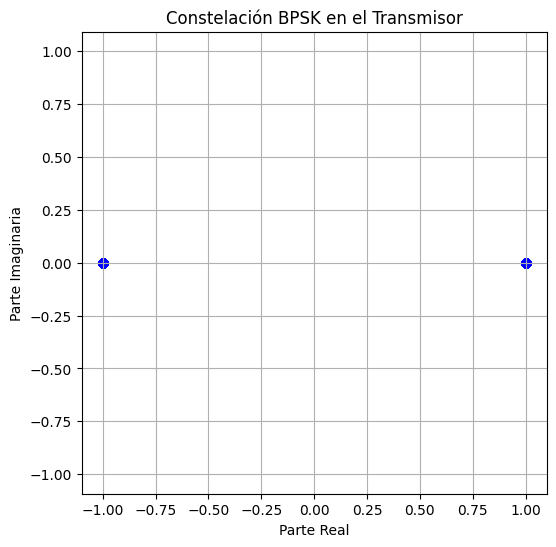

In [5]:
# Visualización de la constelación antes de la transmisión (antes del canal)
plt.figure(figsize=(6,6))
plt.scatter(np.real(symbols), np.imag(symbols), color='blue', alpha=0.5)
plt.title('Constelación BPSK en el Transmisor')
plt.xlabel('Parte Real')
plt.ylabel('Parte Imaginaria')
plt.grid(True)
plt.axis('equal')
plt.show()

### Generar simulación del transmision sobre un canal AWGN 

In [6]:
# Simular transmisión sobre un canal AWGN
def simulate_transmission(signal, snr_db):
    """Simula la transmisión sobre un canal AWGN."""
    # Calcular potencia de señal y ruido
    signal_power = np.mean(np.abs(signal)**2)
    snr_linear = 10**(snr_db / 10)
    noise_power = signal_power / snr_linear

    # Generar ruido blanco gaussiano
    noise = np.sqrt(noise_power / 2) * (
        np.random.randn(len(signal)) + 1j * np.random.randn(len(signal))
    )

    # Añadir ruido a la señal
    received_signal = signal + noise
    return received_signal

received_signal = simulate_transmission(signal_complex, snr_db)

# Guardar la señal recibida para el receptor
np.save('../data/received_signal_simulation.npy', received_signal)

print("Simulación de transmisión completa. Señal guardada para el procesamiento del receptor.")


Simulación de transmisión completa. Señal guardada para el procesamiento del receptor.


## Simulacion del Receptor

Preámbulo detectado en el índice: 0
Desplazamiento de frecuencia estimado (CFO): 0.033302414910182536


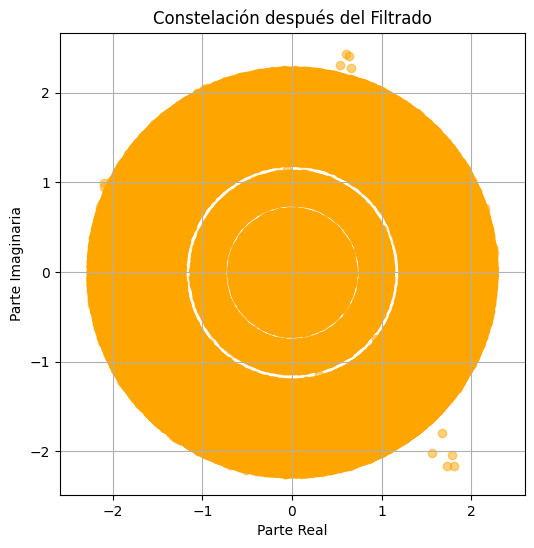

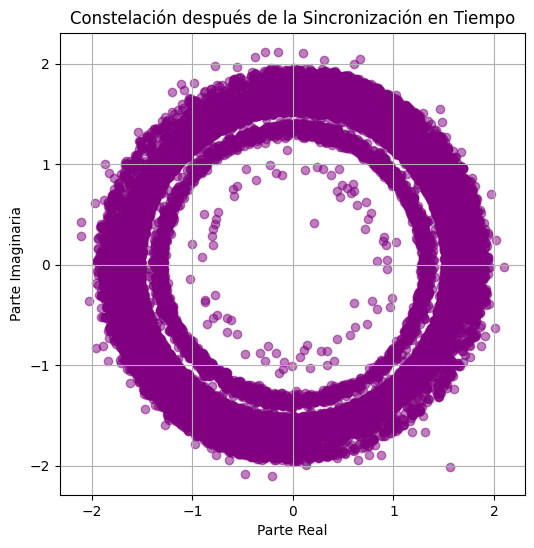

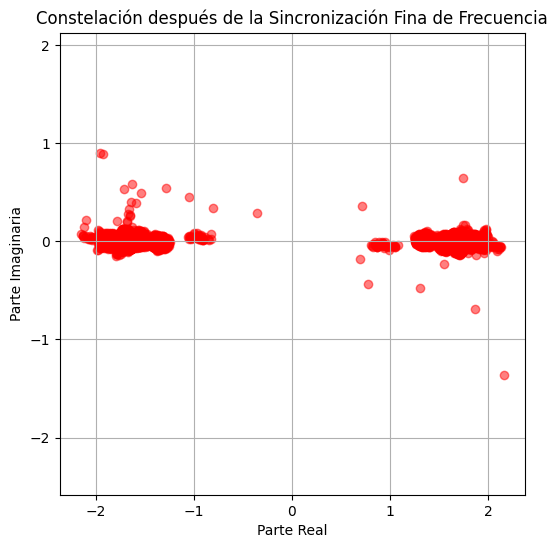

Preamble bits match: True
Ancho de imagen: 600, Alto de imagen: 400


In [7]:
# Parámetros del receptor
samples_per_symbol = 8
beta = 0.2
num_taps = 101
sample_rate = samples_per_symbol  # Debe coincidir con el transmisor

# Cargar señal recibida
received_signal = np.load('../data/received_signal_simulation.npy')

# Cargar bits del preámbulo desde el archivo
preamble_bits = np.load('../data/preamble_bits_simulation.npy')
preamble_symbols = 2 * preamble_bits - 1
L = len(preamble_symbols) * samples_per_symbol

# Detección de preámbulo usando Schmidl & Cox
d_max, M = schmidl_cox_algorithm_vectorized(received_signal, L)
if d_max is not None:
    print(f"Preámbulo detectado en el índice: {d_max}")
    # Estimación del desplazamiento de frecuencia grueso (CFO)
    A = np.sum(received_signal[d_max:d_max+L] * np.conj(received_signal[d_max+L:d_max+2*L]))
    freq_offset_est = (sample_rate / (2 * np.pi * L)) * np.angle(A)
    print(f"Desplazamiento de frecuencia estimado (CFO): {freq_offset_est}")
    # Corregir el desplazamiento de frecuencia grueso
    t = np.arange(len(received_signal)) / sample_rate
    received_signal *= np.exp(-1j * 2 * np.pi * freq_offset_est * t)

    # Filtrado adaptado con filtro RRC
    rrc_coef = rrc_filter(beta, samples_per_symbol, num_taps)
    matched_filtered_signal = np.convolve(received_signal, rrc_coef, mode='same')
    
    # Constelación después del filtrado adaptado
    plt.figure(figsize=(6,6))
    plt.scatter(np.real(matched_filtered_signal), np.imag(matched_filtered_signal), color='orange', alpha=0.5)
    plt.title('Constelación después del Filtrado')
    plt.xlabel('Parte Real')
    plt.ylabel('Parte Imaginaria')
    plt.grid(True)
    plt.axis('equal')
    plt.show()
    
    timing_recovered_signal = mueller_muller_timing_recovery(matched_filtered_signal[d_max:], samples_per_symbol)
    
    # Visualización de la constelación después de la sincronización en tiempo
    plt.figure(figsize=(6,6))
    plt.scatter(np.real(timing_recovered_signal), np.imag(timing_recovered_signal), color='purple', alpha=0.5)
    plt.title('Constelación después de la Sincronización en Tiempo')
    plt.xlabel('Parte Real')
    plt.ylabel('Parte Imaginaria')
    plt.grid(True)
    plt.axis('equal')
    plt.show()
    
    frequency_corrected_signal = costas_loop(timing_recovered_signal)
    
    # Visualización de la constelación después de la sincronización fina de frecuencia
    plt.figure(figsize=(6,6))
    plt.scatter(np.real(frequency_corrected_signal), np.imag(frequency_corrected_signal), color='red', alpha=0.5)
    plt.title('Constelación después de la Sincronización Fina de Frecuencia')
    plt.xlabel('Parte Real')
    plt.ylabel('Parte Imaginaria')
    plt.grid(True)
    plt.axis('equal')
    plt.show()

    # Demodulación (decisión)
    received_symbols = frequency_corrected_signal
    received_bits = (np.real(received_symbols) > 0).astype(np.uint8)

    # Eliminar posibles bits adicionales
    transmitted_bits = np.load('../data/transmitted_bits_simulation.npy')
    received_bits = received_bits[:len(transmitted_bits)]

    # Extraer los bits del preámbulo recibidos
    preamble_received_bits = received_bits[:len(preamble_bits)]

    # Verificación del preámbulo
    preamble_match = np.array_equal(preamble_received_bits, preamble_bits)
    print(f'Preamble bits match: {preamble_match}')

    if not preamble_match:
        print("El preámbulo no coincide. No se puede continuar.")
    else:
        # Ahora aplicar la decodificación de canal al resto de los bits
        received_bits_rest = received_bits[len(preamble_bits):]
        def channel_decode(bits, repetition=3):
            bits = bits[:len(bits) - len(bits) % repetition]  # Ajustar longitud
            bits_reshaped = bits.reshape(-1, repetition)
            decoded_bits = (np.sum(bits_reshaped, axis=1) > (repetition / 2)).astype(np.uint8)
            return decoded_bits

        decoded_bits_rest = channel_decode(received_bits_rest, repetition=3)

        # Concatenar los bits decodificados
        decoded_bits = np.concatenate((preamble_bits, decoded_bits_rest))

        # Extraer y decodificar el encabezado
        header_bits = decoded_bits[len(preamble_bits):len(preamble_bits) + 32]
        width_bits = header_bits[:16]
        height_bits = header_bits[16:32]

        # Convertir bits a bytes
        width_bytes = np.packbits(width_bits)
        height_bytes = np.packbits(height_bits)

        # Convertir bytes a enteros de 16 bits
        width = int(np.frombuffer(width_bytes.tobytes(), dtype='>u2')[0])
        height = int(np.frombuffer(height_bytes.tobytes(), dtype='>u2')[0])

        print(f"Ancho de imagen: {width}, Alto de imagen: {height}")

        # Extraer bits de imagen
        image_bits = decoded_bits[len(preamble_bits) + 32:]
        # Ajustar longitud
        expected_bits = width * height * 3 * 8  # 3 canales (RGB), 8 bits por canal
        image_bits = image_bits[:expected_bits]

        # Convertir bits a bytes
        image_bytes = np.packbits(image_bits)
        # Convertir bytes a matriz de imagen
        image_array = np.reshape(image_bytes, (height, width, 3))
        # Crear y mostrar la imagen
        image = Image.fromarray(image_array, 'RGB')
        image.show()
else:
    print("No se detectó el preámbulo en la señal recibida.")

### Comparación de la imagen original con la reconstruida

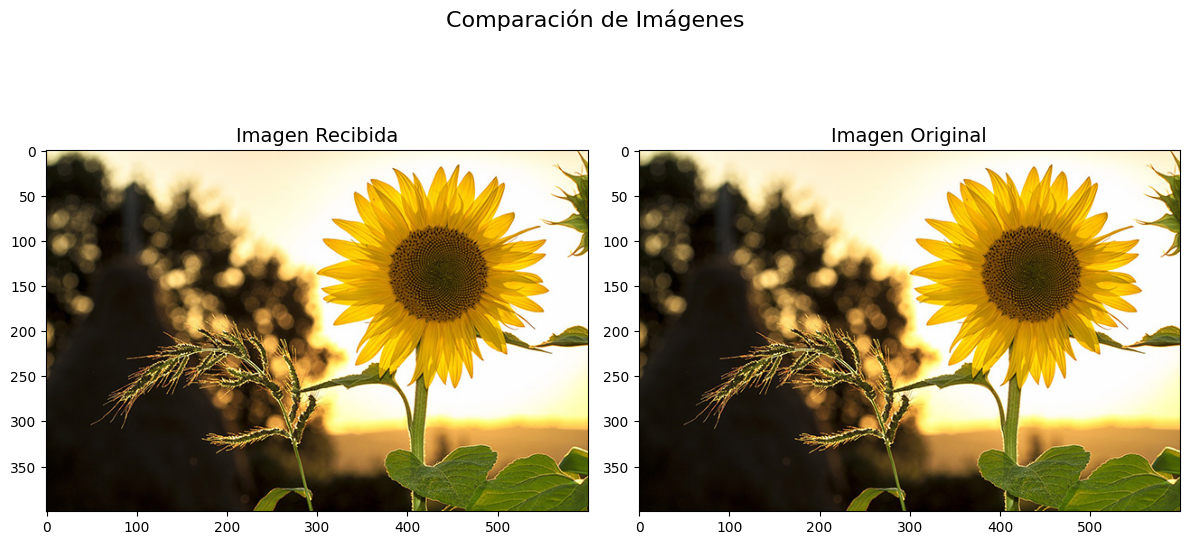

In [9]:
# Mostrar la imagen original y la recibida para comparación usando matplotlib
plt.figure(figsize=(12, 6))
plt.suptitle('Comparación de Imágenes', fontsize=16)

# Imagen recibida
plt.subplot(1, 2, 1)
plt.imshow(image_array)
plt.title('Imagen Recibida', fontsize=14)

# Cargar la imagen original
image_original = Image.open('../images/imagen3.jpg')
image_original = image_original.convert('RGB')
plt.subplot(1, 2, 2)
plt.imshow(image_original)
plt.title('Imagen Original', fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajustar diseño y dejar espacio para el título
plt.show()
